# Import libraries

In [8]:
import numpy as np

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder


from utils import eda_train_df as train_df
from utils import validation_df, test_df, eda_data_dir

## Group by rate

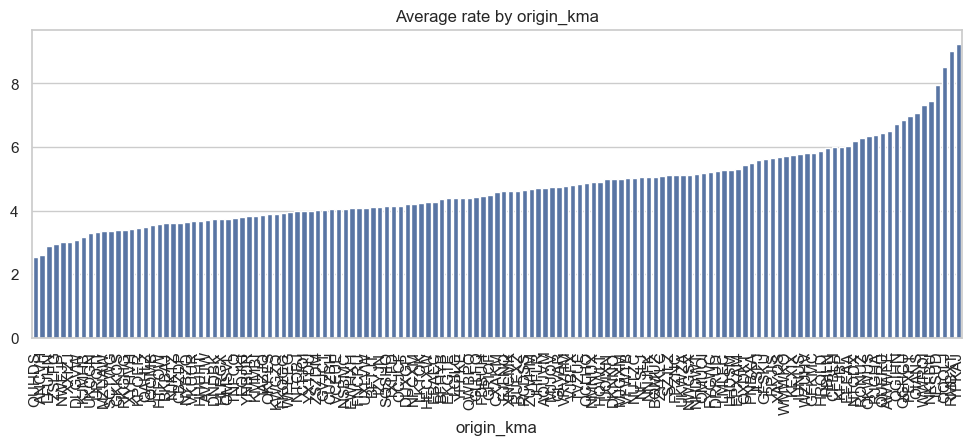

In [2]:
origin_means = train_df.groupby("origin_kma")["rate"].mean().sort_values()
destination_means = train_df.groupby("destination_kma")["rate"].mean().sort_values()

plt.figure(figsize=(12, 4))
sns.barplot(x=origin_means.index, y=origin_means.values)
plt.xticks(rotation=90)
plt.title("Average rate by origin_kma")
plt.show()

- Если количество KMA маленькое (< 50), можно использовать One-Hot Encoding.
- Если больше 100, лучше Target Encoding или Embeddings.
- Лучший метод кодирования → Target Encoding (mean rate по KMA).
- Если KMA очень много (500+), можно попробовать Embeddings.
- 135 уникальных origin_kma и 135 destination_kma → это среднее количество категорий.
- Существенные различия в среднем rate между разными origin_kma → KMA влияет на rate.
- График распределения rate по origin_kma неравномерный → у некоторых KMA средний rate в 2-3 раза выше, чем у других.
- Target Encoding, так как KMA влияет на rate, но их 135 → слишком много для One-Hot.
- Target Encoding (Mean Encoding) — это способ кодирования категориальных признаков, при котором каждая категория заменяется средним значением целевой переменной (rate) внутри этой категории.

- Добавляем два новых признака:
- origin_kma_mean_rate → средний rate по origin_kma.
- destination_kma_mean_rate → средний rate по destination_kma.


| Метод | Когда использовать? | Плюсы| Минусы |
|---|---|---|---|
| **One-Hot Encoding**| Если < 50 категорий | Простая интерпретация, не даёт искажений | Увеличивает размерность данных |
| **Target Encoding (Mean Encoding)** | Если > 50 категорий, но есть сильная связь с `rate` | Компактно, учитывает средний `rate`| Может приводить к ликажу (если считать по train) |
| **Embeddings**| Если > 200 категорий| Можно учитывать нелинейные зависимости | Требует сложных моделей|


| Метод | Описание| Плюсы| Минусы|
| --- | --- | --- | --- |
| **One-Hot Encoding (OHE)**| Создаёт отдельную колонку для каждого `KMA` (0/1) | Простая интерпретация<br>Хорошо работает для небольшого числа категорий| Не масштабируется (135 категорий = 135 новых колонок)<br>Не учитывает порядок категорий |
| **Target Encoding (Mean Encoding)** | Каждое `KMA` заменяется средним `rate` по этой категории| Учитывает влияние `KMA` на `rate`<br>Сохраняет информацию, не увеличивая размерность | Возможен leakage (если не обработать правильно) |
| **Frequency Encoding**| Каждое `KMA` заменяется частотой его встречаемости| Компактное представление<br>Работает в деревьях решений| Не учитывает зависимость с `rate` |
| **Leave-One-Out Encoding (LOO Encoding)** | Как Target Encoding, но исключает текущий объект из расчёта | Уменьшает leakage<br>Лучше для небольших выборок | Всё ещё возможен leakage|
| **Embedding Encoding**| Представляет `KMA` в виде векторного пространства | Учитывает сложные зависимости<br>Хорошо работает в DL| Требует сложной модели<br>Не подходит для классического ML|

# Target Encoding

## Compute mean rate per origin_kma and destination_kma (на train)

In [3]:
origin_kma_map = train_df.groupby("origin_kma")["rate"].mean().to_dict()
destination_kma_map = train_df.groupby("destination_kma")["rate"].mean().to_dict()

## Global mean rate для неизвестных KMA

In [4]:
global_mean_rate = train_df["rate"].mean()

## Функция для Target Encoding с обработкой unseen KMA

In [5]:
def apply_target_encoding(df, origin_map, destination_map, global_mean):
    df["origin_kma_mean_rate"] = df["origin_kma"].map(origin_map).fillna(global_mean)
    df["destination_kma_mean_rate"] = df["destination_kma"].map(destination_map).fillna(global_mean)
    return df

# Target Encoding к train, validation и test

In [6]:
train_df = apply_target_encoding(train_df, origin_kma_map, destination_kma_map, global_mean_rate)
validation_df = apply_target_encoding(validation_df, origin_kma_map, destination_kma_map, global_mean_rate)
test_df = apply_target_encoding(test_df, origin_kma_map, destination_kma_map, global_mean_rate)

# Save current version of `train_df`, `validation` and `test`

In [9]:
train_df.to_csv(eda_data_dir / "train_df.csv", index=False)

In [10]:
validation_df.to_csv(eda_data_dir / "validation_df.csv", index=False)

In [11]:
test_df.to_csv(eda_data_dir / "test_df.csv", index=False)